
# Extrapolating HMI Data


In this example you will be downloading boundary data from VSO, extrapolating
using the potential extrapolator and visualising in MayaVi.


You start by importing the necessary modules.


In [1]:
# Module imports
from solarbextrapolation.map3dclasses import Map3D
from solarbextrapolation.extrapolators import PotentialExtrapolator
from solarbextrapolation.visualisation_functions import visualise

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sunpy-0.7.dev6442-py2.7-linux-x86_64.egg/sunpy/visualization/wcsaxes_compat.py:17: UserWarning: SunPy plotting is improved by installing the WCSAxes module: http://wcsaxes.readthedocs.org/en/latest/index.html
  warnings.warn("SunPy plotting is improved by installing the WCSAxes module: http://wcsaxes.readthedocs.org/en/latest/index.html")


In [2]:
# General imports
import os
import numpy as np
import sunpy.map as mp
from sunpy.net import vso
from astropy import units as u
from mayavi import mlab # Necessary for visulisation
import matplotlib.pyplot as plt
%matplotlib inline

You will retrieve the boundary data from the VSO using the SunPy VSO client.
In this case we will retrieve an SDO HMI line-of-sight magnetogram that was
made on the 14th of February 2011, as used in Sun et al (2012).


In [3]:
# Create a new VSOClient instance
client = vso.VSOClient()

# Build the query, this can return one item, or a list of them to DL matching
# the given filters.
result_hmi = client.query(
    # The following are filters for collecting the desired data.
    vso.attrs.Time((2011, 2, 14, 20, 34, 0), (2011, 2, 14, 21, 0, 0)), # Time range.
    vso.attrs.Instrument('HMI'),               # Helioseismic and Magnetic Imager.
    vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
    vso.attrs.Sample(4000 * u.s)               # Only take a shot every $var seconds.
    # More observables at http://sdac.virtualsolar.org/cgi/show_details?keyword=PHYSOBS
)

# Save the results to fits files. (Using Rice compression if possible)
data_hmi = client.get(result_hmi, methods=('URL-FILE_Rice', 'URL-FILE')).wait()

You may also decide to get the corrisponding SDO AIA data showing the EUV
image at the same time, this can be used to see the flux tubes for comparrison
to the vector field streamlines for visulisation.


In [4]:
# Query VSO.
result_aia = client.query(
    vso.attrs.Time((2011, 2, 14, 20, 34, 0), (2011, 2, 14, 21, 0, 0)), # Time range.
    vso.attrs.Instrument('AIA'),    # Helioseismic and Magnetic Imager.
    vso.attrs.Physobs('intensity'), # Physical observables
    vso.attrs.Sample(4000 * u.s)    # Only take a shot every $var seconds.
    # More observables at http://sdac.virtualsolar.org/cgi/show_details?keyword=PHYSOBS
)

# Save the results to fits files. (Using Rice compression if possible)
data_aia = client.get(result_aia, methods=('URL-FILE_Rice', 'URL-FILE')).wait()

You want to crop on solar-x and solar-y the the active region of interest.
Likewise you want to decide on the altertude ranges to extrapolate within.
Extrapolators use astropy quantities for ranges, importanmtly these are
designed to work with either physical length or angular units, conversion is
done using the assumption the boundary data ios on the surface of the sun and
following the small angle approximation.
In this case we use angular uniits (arcsec specifically) for the zrange
quantity, this is physically meaningless, but gives an easy way to ensure
your zrange is similar to teh other ranges.
We also want extended solar-x and solar-y ranges for plotting the


In [5]:
# Cropping into the active region within the HMI map
xrange = u.Quantity([50,    300] * u.arcsec)
yrange = u.Quantity([-350, -100] * u.arcsec)
zrange = u.Quantity([0,     250] * u.arcsec)

# Open the map and create a cropped version for the extrapolation.
map_hmi = mp.Map(data_hmi[0])
map_hmi_cropped = map_hmi.submap(xrange, yrange)

If your boundary data has a high resolution then you may need to resample to
ensure it extrapolates within a reasonable timeframe.


In [6]:
# Resample boundary data map
shape = u.Quantity([20, 20] * u.pixel)
map_hmi_cropped_resampled = map_hmi_cropped.resample(shape, method='linear')

You can check the resulting generated data by using peek().


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sunpy-0.7.dev6442-py2.7-linux-x86_64.egg/sunpy/map/mapbase.py:1472: Warning: This map is not properly oriented. Plot axes may be incorrect
  Warning)
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


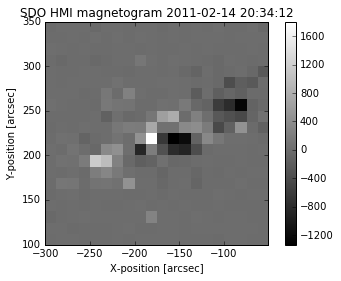

In [7]:
map_hmi_cropped_resampled.peek()

To speed up repeat usage of this script it will save the extrapolation output,
you can use os.path.isfile() to check if the file already exists, assuming it
doesn't you will extrapolate and create it, otherwise you load it.


In [8]:
# Only extrapolate if we don't have a saved version
str_vol_filepath = data_hmi[0][0:-5] + '_Bxyz.npy'
if not os.path.isfile(str_vol_filepath):
    # Create the potential extrapolator and run the extrapolate method.
    aPotExt = PotentialExtrapolator(map_hmi_cropped_resampled, filepath=str_vol_filepath, zshape=20, zrange=zrange)
    aMap3D = aPotExt.extrapolate()
# Load the results.
aMap3D = Map3D.load(str_vol_filepath)
#print '\nextrapolation duration: ' + str(np.round(aMap3D.meta['extrapolator_duration'],3)) + ' s\n'

False


For the perposes of visualisation we will want an extended boundary data, not
just that of the extrapolated region, and at the instruments full resolution,
not resampled.


In [9]:
xrangeextended = u.Quantity([ xrange.value[0] - 50, xrange.value[1] + 50 ] * xrange.unit)
yrangeextended = u.Quantity([ yrange.value[0] - 50, yrange.value[1] + 50 ] * yrange.unit)

# Open the map and create a cropped version for the visualisation.
map_boundary = mp.Map(data_hmi[0])
map_boundary_cropped = map_boundary.submap(xrangeextended, yrangeextended)

You can now get a quick and easy visualisation using the
solarbextrapolation.example_data_generator.visualise tools:


In [10]:
# Visualise the 3D vector field
visualise(aMap3D, boundary=map_boundary_cropped, scale=1.0*u.Mm, boundary_unit=1.0*u.arcsec, show_boundary_axes=False, show_volume_axes=True, debug=False)
mlab.show()

shape: (20, 20, 20, 3)


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/solarbextrapolation-0.1.dev119-py2.7.egg/solarbextrapolation/map3dclasses.py:146: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  Warning)
